In [11]:
import numpy as np
import pandas as pd
import tidyms as ms
import bokeh
import seaborn as sns
import matplotlib.pyplot as plt
from utils import data_container_from_csv

pd.set_option("display.precision", 4)
from matplotlib.cm import get_cmap
plt.style.use("plot_style.stl")

In [2]:
set2 = get_cmap("Set2").colors

palette = {
    "study sample": set2[-1],
    "SRM": set2[3],
    "QC": set2[4]
}
set2 = get_cmap("tab10").colors
palette = {"study sample": set2[-3], "SRM": set2[1], "QC": set2[0]}

In [3]:
# load raw DataContainer
data_raw = data_container_from_csv("data/raw")
data_curated = data_container_from_csv("data/curated")

In [4]:
# remove samples from additional experiments
crm = ms.filter.ClassRemover(["0", "1", "2", "4", "8", "16", "0", "sss"])
crm.process(data_raw)

# update class names for plots
class_mapping = {x: x for x in data_raw.classes.unique()}
study_classes = ["healthy", "benign", "post-surgery", "cancer"]
blank_classes = ["process blank", "solvent", "zero"]
study_mapping = {x: "study sample" for x in study_classes}
blank_mapping = {x: "blank" for x in blank_classes}
class_mapping.update(blank_mapping)
class_mapping.update(study_mapping)
class_mapping["cQC"] = "conditioning QC"
data_raw._sample_metadata["class"] = data_raw._sample_metadata["class"].map(class_mapping)
data_curated._sample_metadata["class"] = data_curated._sample_metadata["class"].map(class_mapping)

## Figure 1: Sample list, PCA and IS signal

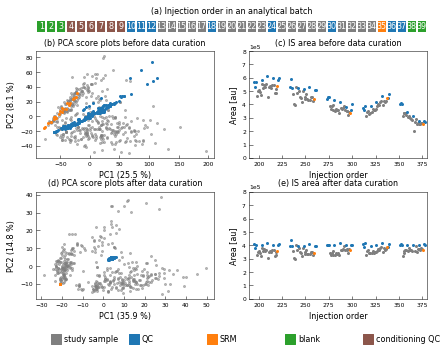

In [12]:
fig = plt.figure(figsize=(7, 6))
spec = fig.add_gridspec(21, 2)

# sample list
ax0 = fig.add_subplot(spec[0, :])
df = pd.read_csv("data/sample-list-template.csv")
cfactors, c_unique = pd.factorize(df["sample type"])
cfactors = np.reshape(cfactors, (1, cfactors.size))
palette ={k: set2[k] for k in range(c_unique.size)}
type_to_color = {
    "study sample": "tab:gray",
    "QC": "tab:blue",
    "SRM": "tab:orange",
    "blank": "tab:green",
    "conditioning QC": "tab:brown"
}
p = [type_to_color[x] for x in c_unique]

sns.heatmap(
    cfactors,
    linewidths=0.1,
    ax=ax0,
    cbar=None,
    cmap=p,
    vmin=0,
    vmax=4,
    annot=np.arange(cfactors.size).reshape((1, cfactors.size)) + 1
)
ax0.set_title("(a) Injection order in an analytical batch")
ax0.set_xticks([])
ax0.set_yticks([])


# PCA raw data
ax = fig.add_subplot(spec[2:9, 0])
ignore = ["blank"]
data = data_raw
classes = data.classes[~data.classes.isin(ignore)].to_numpy()
scores, loadings, pc_var, total_var = data.metrics.pca(
    scaling="autoscaling",
    ignore_classes=ignore
)
pc1, pc2 = scores.to_numpy().T
rel_var = pc_var / total_var
for c, color in type_to_color.items():
    mask = classes == c
    if c == "study sample":
        alpha = 0.5
    else:
        alpha = 1.0
    ax.scatter(pc1[mask], pc2[mask], color=color, alpha=alpha, edgecolors=None)
ax.set_xlabel("PC1 ({:.1f} %)".format(rel_var[0] * 100))
ax.set_ylabel("PC2 ({:.1f} %)".format(rel_var[1] * 100))
ax.set_title("(b) PCA score plots before data curation")

# # Lacosamide raw
lacosamide_mz = 249.1249
lacosamide_rt = 3.85 * 60
ft_name = data.select_features(lacosamide_mz, lacosamide_rt)[0]
data = data_raw
classes = data.classes[~data.classes.isin(ignore)].to_numpy()
x = data.order[~data.classes.isin(ignore)].to_numpy()
y = data.data_matrix.loc[~data.classes.isin(ignore), ft_name].to_numpy()
ax = fig.add_subplot(spec[2:9, 1])
for c, color in type_to_color.items():
    mask = classes == c
    ax.scatter(x[mask], y[mask], color=color, edgecolors=None)
ax.set_xlabel("Injection order")
ax.set_ylabel("Area [au]")
ax.set_title("(c) IS area before data curation")
ax.set_xlim(190, 380)
ax.set_ylim(0, 8e5)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

# PCA raw data
ax = fig.add_subplot(spec[11:18, 0])
ignore = ["blank"]
data = data_curated
classes = data.classes[~data.classes.isin(ignore)].to_numpy()
scores, loadings, pc_var, total_var = data.metrics.pca(
    scaling="autoscaling",
    ignore_classes=ignore
)
pc1, pc2 = scores.to_numpy().T
rel_var = pc_var / total_var
for c, color in type_to_color.items():
    mask = classes == c
    if c == "study sample":
        alpha = 0.5
    else:
        alpha = 1.0
    ax.scatter(pc1[mask], pc2[mask], color=color, alpha=alpha, edgecolors=None)
ax.set_xlabel("PC1 ({:.1f} %)".format(rel_var[0] * 100))
ax.set_ylabel("PC2 ({:.1f} %)".format(rel_var[1] * 100))
ax.set_title("(d) PCA score plots after data curation")


# Lacosamide curated
lacosamide_mz = 249.1249
lacosamide_rt = 3.85 * 60
ft_name = data.select_features(lacosamide_mz, lacosamide_rt)[0]
data = data_curated
classes = data.classes[~data.classes.isin(ignore)].to_numpy()
x = data.order[~data.classes.isin(ignore)].to_numpy()
y = data.data_matrix.loc[~data.classes.isin(ignore), ft_name].to_numpy()
ax = fig.add_subplot(spec[11:18, 1])
for c, color in type_to_color.items():
    mask = classes == c
    ax.scatter(x[mask], y[mask], color=color, edgecolors=None)
ax.set_xlabel("Injection order")
ax.set_ylabel("Area [au]")
ax.set_title("(e) IS area after data curation")
ax.set_xlim(190, 380)
ax.set_ylim(0, 8e5)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))


# legend
ax = fig.add_subplot(spec[20:, :])
size = len(type_to_color)
for k, (c_str, color) in enumerate(type_to_color.items()):
    ax.scatter(k / len(type_to_color), 0.5, marker="s", s=100, color=color)
    ax.annotate(c_str, (k / size + 0.02, 0.3))
ax.set_ylim(0, 1)
ax.set_xlim(-0.05, 0.95)
ax.edgecolors = None
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor([1, 1, 1, 0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

fig.savefig("figures/sample-list-tidyms.png", dpi=300, facecolor="white")

## Figure 2: CV of technical and process replicates

In [13]:
data = data_container_from_csv("data/curated-no-cv-filter")
rep_cv = data.metrics.cv(["batch", "class"], robust=True)

cv_pqc = rep_cv.loc[(27, "pQC")]
cv_qc = rep_cv.loc[(27, "QC")]

mask = cv_pqc != np.inf
cv_pqc = cv_pqc[mask]
cv_qc = cv_qc[mask]

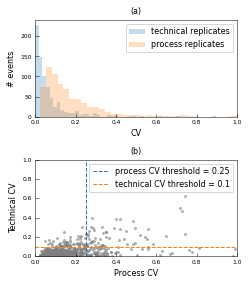

In [20]:
figsize = (3.5, 4)
fig, ax = plt.subplots(figsize=figsize, nrows=2)

cax = ax[0]
cax.hist(cv_qc, bins=50, label="technical replicates", alpha=0.25)
cax.hist(cv_pqc, bins=50, label="process replicates", alpha=0.25)
cax.set_xlabel("CV")
cax.set_ylabel("# events")
cax.legend()
cax.set_xlim(0, 1)
cax.set_title("(a)")

cax = ax[1]
cax.scatter(cv_pqc, cv_qc, color="tab:gray", alpha=0.5, edgecolor=None)
cax.vlines(0.25, 0, 1, color="tab:blue", linestyle="--", label="process CV threshold = 0.25")
cax.hlines(0.1, 0, 1, color="tab:orange", linestyle="--",  label="technical CV threshold = 0.1")
cax.set_xlabel("Process CV")
cax.set_ylabel("Technical CV")
cax.set_xlim(0, 1)
cax.set_ylim(0, 1)
cax.set_title("(b)")
cax.legend()
fig.tight_layout()
fig.savefig("figures/cv-replicates-tidyms.png", dpi=300, facecolor="white")

## Figure 3: Histogram of correlation distribution for QC samples

In [15]:
def corr_pairs(X: np.ndarray, qc_class="QC"):
    n_sample, n_ft = X.shape
    with np.errstate(divide="ignore"):
        r = np.corrcoef(X.T)
        r = r.flatten()
    rm_index = np.hstack([np.arange(k + 1) + k * n_ft for k in range(n_ft)])
    r = np.delete(r, rm_index)
    r = r[~np.isnan(r)]
    return r

In [16]:
xraw = data_raw.data_matrix[data_raw.classes == "QC"].to_numpy()
rraw = corr_pairs(xraw)
rraw_mean = np.median(rraw)

xcurated = data_curated.data_matrix[data_curated.classes == "QC"].to_numpy()
rcurated = corr_pairs(xcurated)
rcurated_mean = np.median(rcurated)

xsim = np.random.normal(size=xcurated.shape)
rsim = corr_pairs(xsim)
rsim_mean = np.median(xsim)

# histograms
bins = np.linspace(-1, 1, 41)
raw_d = np.histogram(rraw, density=True, bins=bins)[0]
raw_mean_ind = np.searchsorted(bins, rraw_mean) - 1

curated_d = np.histogram(rcurated, density=True, bins=bins)[0]
curated_mean_ind = np.searchsorted(bins, rcurated_mean) - 1

sim_d = np.histogram(rsim, density=True, bins=bins)[0]
sim_mean_ind = np.searchsorted(bins, rsim_mean) - 1


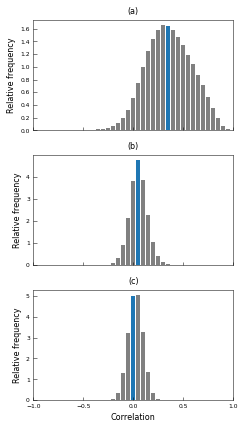

In [21]:
figsize = (3.5, 6)
fig, ax = plt.subplots(nrows=3, figsize=figsize, sharex=True)

# raw hist
raw_colors = ["grey" for x in range(bins.size)]
raw_colors[raw_mean_ind] = "tab:blue"
cax = ax[0]
cax.bar(bins[:-1] + 0.05, raw_d, width=0.04, color=raw_colors)
cax.set_xlim(-1, 1)
cax.set_ylabel("Relative frequency")
cax.set_xticks([-1, -0.5, 0, 0.5, 1])
cax.set_title("(a)")

# curated hist
curated_colors = ["grey" for x in range(bins.size)]
curated_colors[curated_mean_ind] = "tab:blue"
cax = ax[1]
cax.bar(bins[:-1] + 0.05, curated_d, width=0.04, color=curated_colors)
cax.set_xlim(-1, 1)
cax.set_ylabel("Relative frequency")
cax.set_title("(b)")

# simulated hist
sim_colors = ["grey" for x in range(bins.size)]
sim_colors[sim_mean_ind] = "tab:blue"
cax = ax[2]
cax.bar(bins[:-1] + 0.05, sim_d, width=0.04, color=sim_colors)
cax.set_xlim(-1, 1)
cax.set_xlabel("Correlation")
cax.set_ylabel("Relative frequency")
cax.set_title("(c)")

fig.tight_layout()
fig.savefig("figures/corr-hist-tidyms.png", dpi=300, facecolor="white")

## Plotting correlation histograms using TidyMS

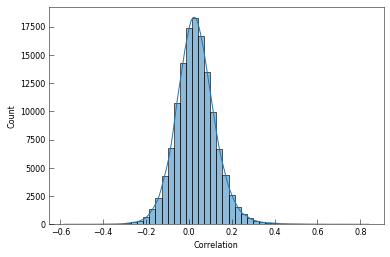

In [11]:
data_curated.set_plot_mode("seaborn")
data_curated.mapping = {"qc": ["QC"]}
data_curated.plot.correlation_histogram(bins=50, kde=True)

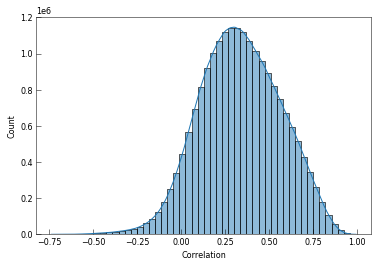

In [12]:
data_raw.set_plot_mode("seaborn")
data_raw.mapping = {"qc": ["QC"]}
data_raw.plot.correlation_histogram(bins=50, kde=True)